# Sanity Check of Cleaned data

### Helper funcitons

In [77]:
import pandas as pd
import datetime as dt

# Function to load a CSV file
def load_csv_file(file_path):
    """Loads a CSV file into a pandas DataFrame and returns it."""
    try:
        df = pd.read_csv(file_path)
        # print(f"Successfully loaded '{file_path}'. Head of the DataFrame:")
        # print(df.head())
        return df
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please check the path.")
        return None
    except Exception as e:
        print(f"An error occurred while loading the CSV: {e}")
        return None

# Funtion to check Null Values in CSV
def check_null_values(df, df_name):
    """Checks and prints the sum of null values for each column in a DataFrame."""
    print(f"\n--- Null values in {df_name} ---")
    null_counts = df.isnull().sum()
    if null_counts.sum() == 0:
        print(f"No null values found in {df_name}.")
    else:
        print(null_counts[null_counts > 0])



def flag_outside_opening_hours(
    df,
    timestamp_col="timestamp",
    open_col="Opening",
    close_col="Closing_adj",
    output_col="outside_opening_hours"
):
    """
    Flags rows where timestamp is outside row-specific opening hours.
    Assumes opening hours do NOT cross midnight.
    """

    
    out = df.copy()

    time = pd.to_datetime(out[timestamp_col]).dt.time
    open_t = pd.to_datetime(out[open_col]).dt.time
    close_t = pd.to_datetime(out[close_col]).dt.time

    out[output_col] = (
        (time < open_t) |
        (time > close_t)
    )

    return out

def flag_inside_opening_hours(
    df,
    timestamp_col="timestamp",
    open_col="Opening",
    close_col="Closing_adj",
    output_col="inside_opening_hours"
):
    """
    Flags rows where timestamp is outside row-specific opening hours.
    Assumes opening hours do NOT cross midnight.
    """

    
    out = df.copy()

    time = pd.to_datetime(out[timestamp_col]).dt.time
    open_t = pd.to_datetime(out[open_col]).dt.time
    close_t = pd.to_datetime(out[close_col]).dt.time

    out[output_col] = (
        (time >= open_t) &
        (time <= close_t)
    )

    return out



### Load all cleaned csv files 

In [78]:
import pandas as pd 

estimate_df = load_csv_file('data/' + 'estimate_during_opening_hours.csv')
manual_df = load_csv_file('data/' + 'manual_counts_during_opening_hours.csv')
clients_df = load_csv_file('data/' + 'wlan_clients_during_opening_hours.csv')


In [79]:
locations_df = load_csv_file('data/' + 'locations.csv')

#locations_df.head(30)
clients_df.head()

,id,location_id,numberofclients,timestamp,Opening,Closing,Closing_adj,event_time
0,5,18,32,2016-04-12 13:01:09,08:00:00,19:45:00,19:45:00,13:01:09
1,6,17,37,2016-04-12 13:01:09,08:00:00,19:45:00,19:45:00,13:01:09
2,7,19,14,2016-04-12 13:01:09,08:00:00,19:45:00,19:45:00,13:01:09
3,8,20,42,2016-04-12 13:01:09,00:00:00,00:00:00,23:59:59.999999,13:01:09
4,9,15,15,2016-04-12 13:01:09,08:00:00,00:00:00,23:59:59.999999,13:01:09


## Sanity Check: Are any data points left outside of opening hours 

In [80]:
estimate_df_checked = flag_outside_opening_hours(estimate_df)
manual_df_checked = flag_outside_opening_hours(manual_df)
clients_df_checked = flag_outside_opening_hours(clients_df)

/var/folders/9t/s3bwp7yx0j15db_p91_vyh680000gn/T/ipykernel_25150/2277567978.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  open_t = pd.to_datetime(out[open_col]).dt.time
/var/folders/9t/s3bwp7yx0j15db_p91_vyh680000gn/T/ipykernel_25150/2277567978.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  close_t = pd.to_datetime(out[close_col]).dt.time
/var/folders/9t/s3bwp7yx0j15db_p91_vyh680000gn/T/ipykernel_25150/2277567978.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  open_t = pd.to_datetime(out[open_col]).dt.time
/var/folders/9t/s3bwp7yx0j15db_p91_vyh680000gn/T/i

In [81]:
# checks if there are any TRUE flags in the outside opening hours column which would indicate values outside the opening hours 
assert not estimate_df_checked["outside_opening_hours"].any()
assert not manual_df_checked["outside_opening_hours"].any()
assert not clients_df_checked["outside_opening_hours"].any()

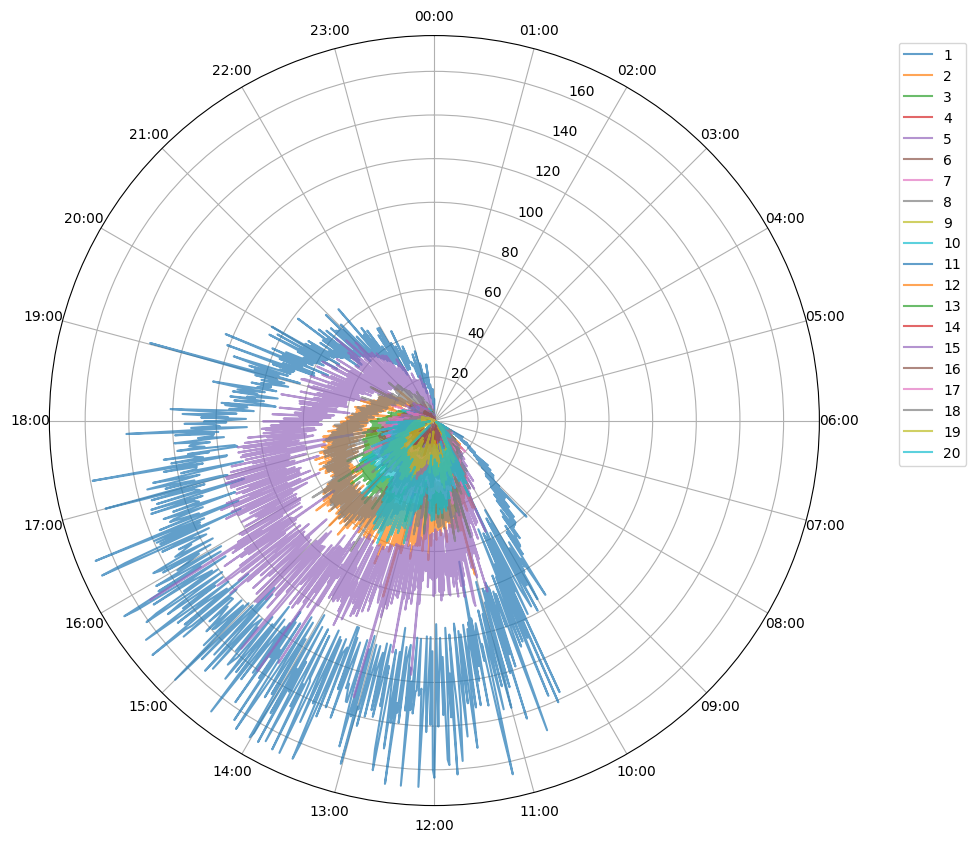

In [82]:
# additional plotting as a sanity check 
# creating a polar plot with the average over the day of every location 
import matplotlib.pyplot as plt
import numpy as np 

# convert to datetime
estimate_df["timestamp"] = pd.to_datetime(estimate_df["timestamp"], errors="raise")
manual_df["timestamp"] = pd.to_datetime(manual_df["timestamp"], errors="raise")
clients_df["timestamp"] = pd.to_datetime(clients_df["timestamp"], errors="raise")


estimate_df["hour"] = estimate_df["timestamp"].dt.hour + estimate_df["timestamp"].dt.minute / 60
avg = (estimate_df.groupby(["location_id", "hour"])["occupiedseats"].mean().reset_index())
avg["theta"] = 2 * np.pi * avg["hour"] / 24

# set axis as hours 
hours = np.arange(0, 24, 1)
hour_angles = 2 * np.pi * hours / 24


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="polar")

for loc, g in avg.groupby("location_id"):
    ax.plot(g["theta"], g["occupiedseats"], label=str(loc), alpha=0.7)

ax.set_xticks(hour_angles)
ax.set_xticklabels([f"{h:02d}:00" for h in hours])
ax.set_theta_zero_location("N")   # midnight at top
ax.set_theta_direction(-1)        # clockwise
ax.legend(bbox_to_anchor=(1.2, 1.0))
plt.show()




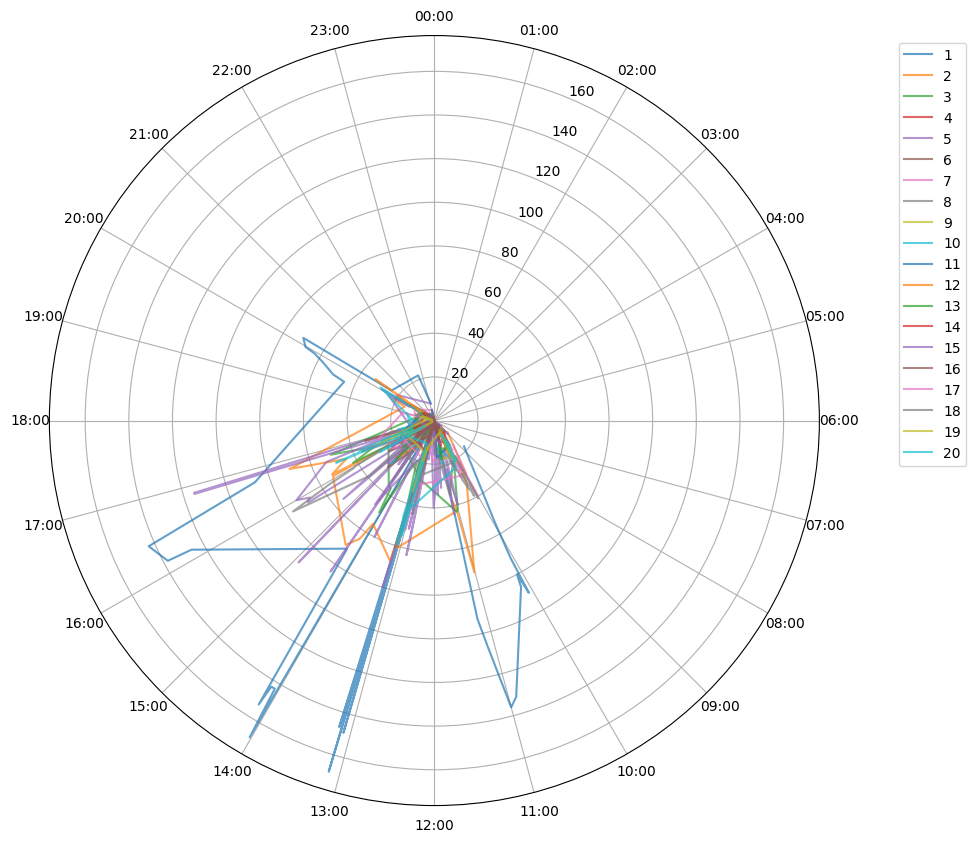

In [83]:
# polar plot for manual count
manual_df["hour"] = manual_df["timestamp"].dt.hour + manual_df["timestamp"].dt.minute / 60
avg_manual = (manual_df.groupby(["location_id", "hour"])["occupiedseats"].mean().reset_index())
avg_manual["theta"] = 2 * np.pi * avg_manual["hour"] / 24


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="polar")

for loc, g in avg_manual.groupby("location_id"):
    ax.plot(g["theta"], g["occupiedseats"], label=str(loc), alpha=0.7)

ax.set_xticks(hour_angles)
ax.set_xticklabels([f"{h:02d}:00" for h in hours])
ax.set_theta_zero_location("N")   # midnight at top
ax.set_theta_direction(-1)        # clockwise
ax.legend(bbox_to_anchor=(1.2, 1.0))
plt.show()



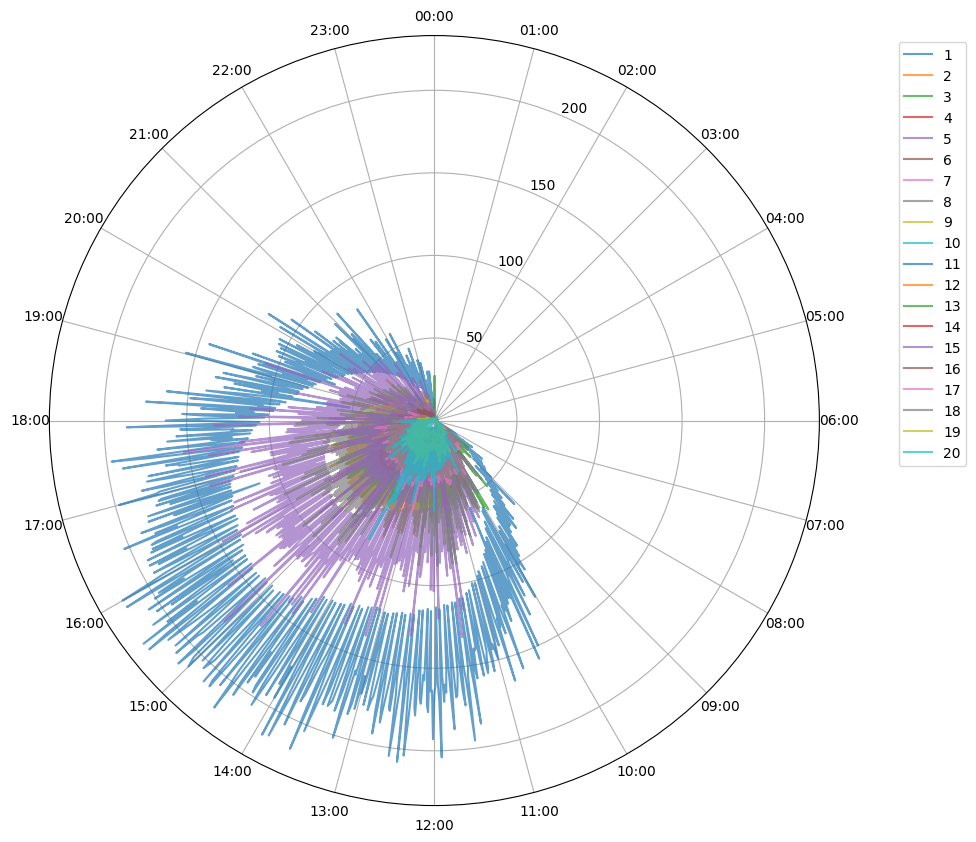

In [84]:
# polar plot for wlan clients
clients_df["hour"] = clients_df["timestamp"].dt.hour + clients_df["timestamp"].dt.minute / 60
avg_clients = (clients_df.groupby(["location_id", "hour"])["numberofclients"].mean().reset_index())
avg_clients["theta"] = 2 * np.pi * avg_clients["hour"] / 24


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="polar")

for loc, g in avg_clients.groupby("location_id"):
    ax.plot(g["theta"], g["numberofclients"], label=str(loc), alpha=0.7)

ax.set_xticks(hour_angles)
ax.set_xticklabels([f"{h:02d}:00" for h in hours])
ax.set_theta_zero_location("N")   # midnight at top
ax.set_theta_direction(-1)        # clockwise
ax.legend(bbox_to_anchor=(1.2, 1.0))
plt.show()

## Sanity Check: Are there any data points in the deleted csv files with the saved data points outside the openining hours?

In [85]:
import pandas as pd 

estimate_df_deleted = load_csv_file('data/' + 'estimate_deleted_data.csv')
manual_df_deleted = load_csv_file('data/' + 'manual_counts_deleted_data.csv')
clients_df_deleted = load_csv_file('data/' + 'wlan_clients_deleted_data.csv')

In [86]:
estimate_df_deleted_checked = flag_inside_opening_hours(estimate_df_deleted)
manual_df_deleted_checked = flag_inside_opening_hours(manual_df_deleted)
clients_df_deleted_checked = flag_inside_opening_hours(clients_df_deleted)

clients_df_deleted_checked.head()

/var/folders/9t/s3bwp7yx0j15db_p91_vyh680000gn/T/ipykernel_25150/2277567978.py:73: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  open_t = pd.to_datetime(out[open_col]).dt.time
/var/folders/9t/s3bwp7yx0j15db_p91_vyh680000gn/T/ipykernel_25150/2277567978.py:74: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  close_t = pd.to_datetime(out[close_col]).dt.time
/var/folders/9t/s3bwp7yx0j15db_p91_vyh680000gn/T/ipykernel_25150/2277567978.py:73: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  open_t = pd.to_datetime(out[open_col]).dt.time
/var/folders/9t/s3bwp7yx0j15db_p91_vyh680000gn/T/i

,id,location_id,numberofclients,timestamp,Opening,Closing,Closing_adj,event_time,inside_opening_hours
0,1620,18,0,2016-04-12 19:47:18,08:00:00,19:45:00,19:45:00,19:47:18,False
1,1621,17,1,2016-04-12 19:47:18,08:00:00,19:45:00,19:45:00,19:47:18,False
2,1622,19,0,2016-04-12 19:47:18,08:00:00,19:45:00,19:45:00,19:47:18,False
3,1639,18,0,2016-04-12 19:53:16,08:00:00,19:45:00,19:45:00,19:53:16,False
4,1640,17,1,2016-04-12 19:53:16,08:00:00,19:45:00,19:45:00,19:53:16,False


In [87]:
# checks if there are any TRUE flags in the inside opening hours column which would indicate values inside the opening hours 
assert not estimate_df_deleted_checked["inside_opening_hours"].any()
assert not manual_df_deleted_checked["inside_opening_hours"].any()
#clients_df_deleted_checked["inside_opening_hours"].value_counts()
assert not clients_df_deleted_checked["inside_opening_hours"].any()

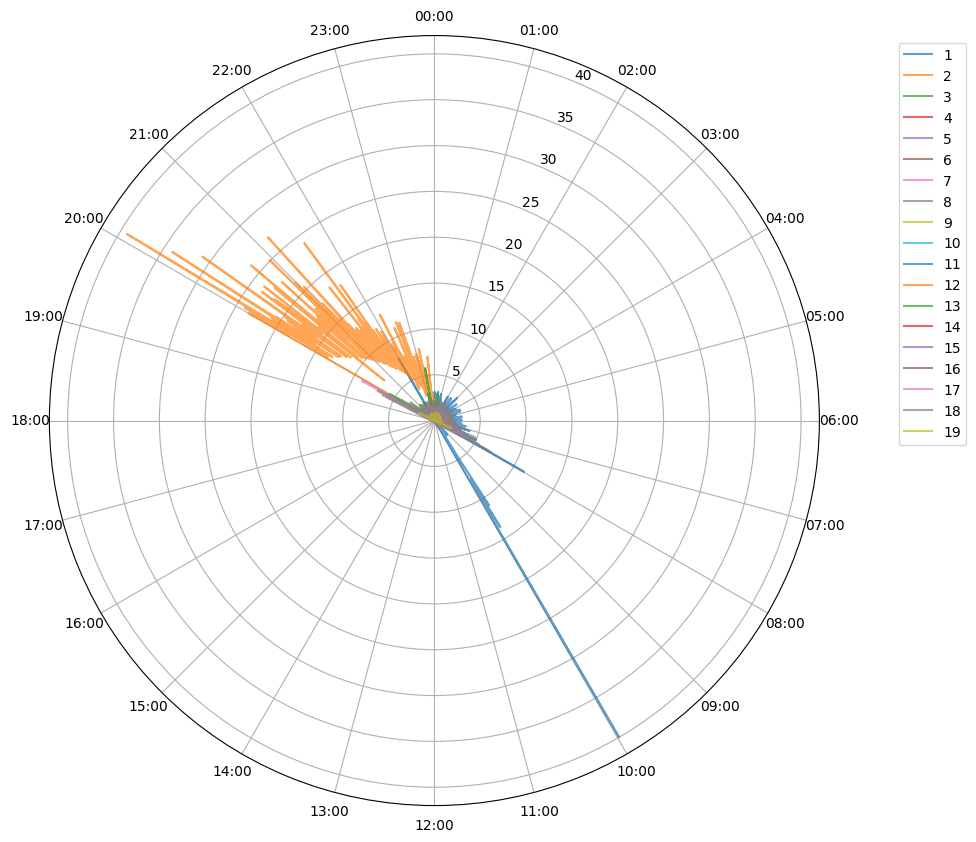

In [88]:
# additional plotting as a sanity check 
# creating a polar plot with the average over the day of every location 
import matplotlib.pyplot as plt
import numpy as np 

# convert to datetime
#estimate_df_deleted["timestamp"] = pd.to_datetime(estimate_df_deleted["timestamp"], errors="raise")
#manual_df_deleted["timestamp"] = pd.to_datetime(manual_df_deleted["timestamp"], errors="raise")
clients_df_deleted["timestamp"] = pd.to_datetime(clients_df_deleted["timestamp"], errors="raise")


clients_df_deleted["hour"] = clients_df_deleted["timestamp"].dt.hour + clients_df_deleted["timestamp"].dt.minute / 60
avg_clients_deleted = (clients_df_deleted.groupby(["location_id", "hour"])["numberofclients"].mean().reset_index())
avg_clients_deleted["theta"] = 2 * np.pi * avg_clients_deleted["hour"] / 24

# set axis as hours 
hours = np.arange(0, 24, 1)
hour_angles = 2 * np.pi * hours / 24


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="polar")

for loc, g in avg_clients_deleted.groupby("location_id"):
    ax.plot(g["theta"], g["numberofclients"], label=str(loc), alpha=0.7)

ax.set_xticks(hour_angles)
ax.set_xticklabels([f"{h:02d}:00" for h in hours])
ax.set_theta_zero_location("N")   # midnight at top
ax.set_theta_direction(-1)        # clockwise
ax.legend(bbox_to_anchor=(1.2, 1.0))
plt.show()

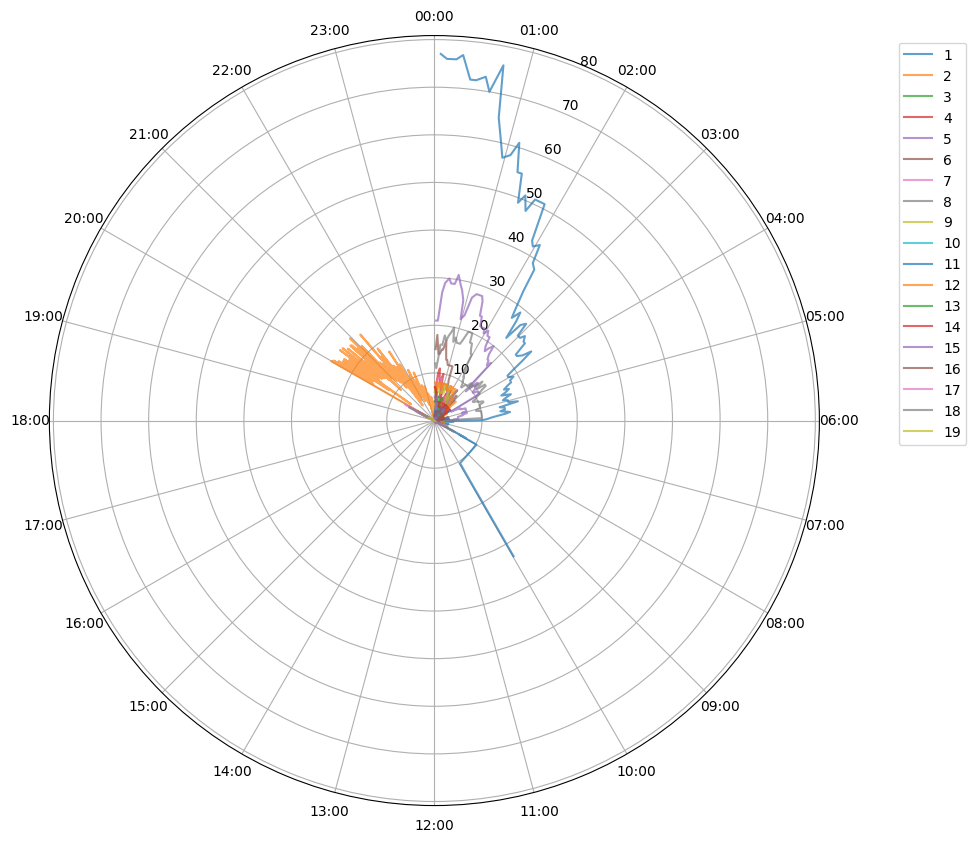

In [89]:
# additional plotting as a sanity check 
# creating a polar plot with the average over the day of every location 


# convert to datetime
estimate_df_deleted["timestamp"] = pd.to_datetime(estimate_df_deleted["timestamp"], errors="raise")



estimate_df_deleted["hour"] = estimate_df_deleted["timestamp"].dt.hour + estimate_df_deleted["timestamp"].dt.minute / 60
avg_estimates_deleted = (estimate_df_deleted.groupby(["location_id", "hour"])["occupiedseats"].mean().reset_index())
avg_estimates_deleted["theta"] = 2 * np.pi * avg_estimates_deleted["hour"] / 24

# set axis as hours 
hours = np.arange(0, 24, 1)
hour_angles = 2 * np.pi * hours / 24


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="polar")

for loc, g in avg_estimates_deleted.groupby("location_id"):
    ax.plot(g["theta"], g["occupiedseats"], label=str(loc), alpha=0.7)

ax.set_xticks(hour_angles)
ax.set_xticklabels([f"{h:02d}:00" for h in hours])
ax.set_theta_zero_location("N")   # midnight at top
ax.set_theta_direction(-1)        # clockwise
ax.legend(bbox_to_anchor=(1.2, 1.0))
plt.show()

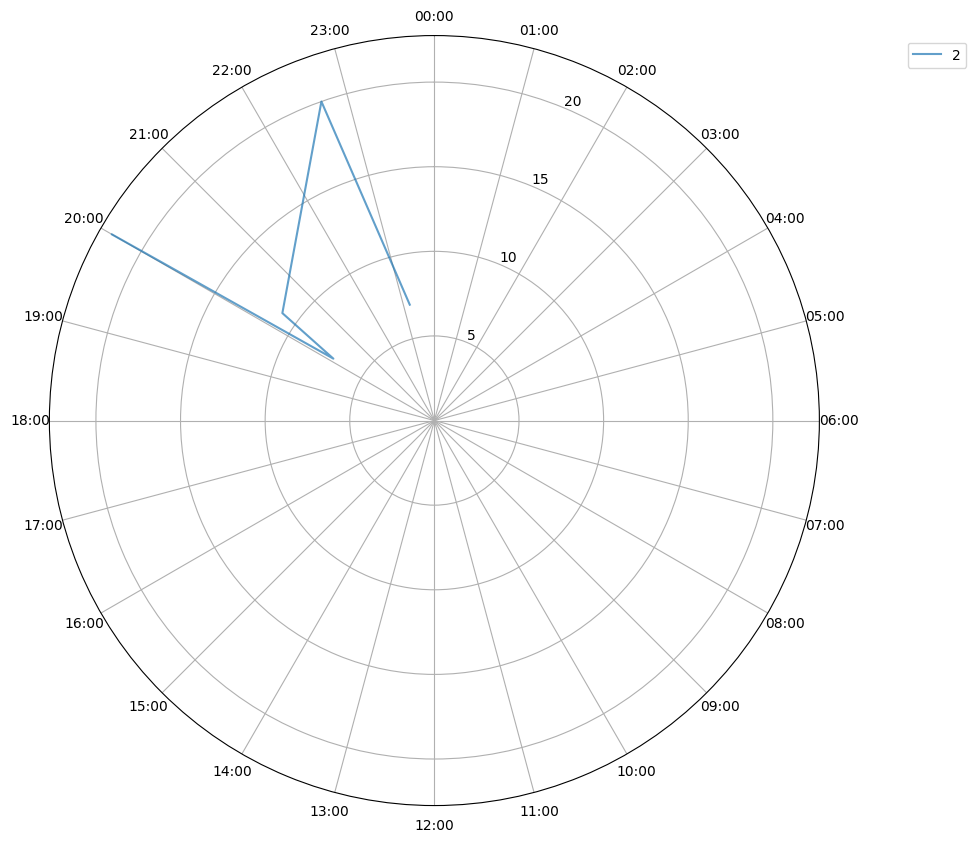

In [90]:
# additional plotting as a sanity check 
# creating a polar plot with the average over the day of every location 
import matplotlib.pyplot as plt
import numpy as np 

# convert to datetime

manual_df_deleted["timestamp"] = pd.to_datetime(manual_df_deleted["timestamp"], errors="raise")


manual_df_deleted["hour"] = manual_df_deleted["timestamp"].dt.hour + manual_df_deleted["timestamp"].dt.minute / 60
avg_manual_deleted = (manual_df_deleted.groupby(["location_id", "hour"])["occupiedseats"].mean().reset_index())
avg_manual_deleted["theta"] = 2 * np.pi * avg_manual_deleted["hour"] / 24

# set axis as hours 
hours = np.arange(0, 24, 1)
hour_angles = 2 * np.pi * hours / 24


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="polar")

for loc, g in avg_manual_deleted.groupby("location_id"):
    ax.plot(g["theta"], g["occupiedseats"], label=str(loc), alpha=0.7)

ax.set_xticks(hour_angles)
ax.set_xticklabels([f"{h:02d}:00" for h in hours])
ax.set_theta_zero_location("N")   # midnight at top
ax.set_theta_direction(-1)        # clockwise
ax.legend(bbox_to_anchor=(1.2, 1.0))
plt.show()